# Few shot pour la classification de signaux 

## Imports et chargement des données

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

paths = {
    "train": "data/train.hdf5",
    "enroll": "data/endroll.hdf5",
    "test": "data/test_fewshot.hdf5"
}

for name, path in paths.items():
    print(f"\n=== {name.upper()} ===")
    with h5py.File(path, "r") as f:
        print("Clés :", list(f.keys()))




=== TRAIN ===
Clés : ['label_name', 'labels', 'signaux', 'snr']

=== ENROLL ===
Clés : ['labels', 'signaux', 'snr']

=== TEST ===
Clés : ['labels', 'signaux', 'snr']


## Description des données

In [6]:
def inspect_dataset(path):
    with h5py.File(path, "r") as f:
        X = f["signaux"]
        y = f["labels"]
        
        print("Shape des signaux :", X.shape)
        print("Shape des labels :", y.shape)
        print("Type des signaux :", X.dtype)
        print("Type des labels :", y.dtype)
        print("Exemple signal shape :", X[0].shape)

inspect_dataset(paths["train"])
inspect_dataset(paths["enroll"])
inspect_dataset(paths["test"])


Shape des signaux : (30000, 2048, 2)
Shape des labels : (30000,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)
Shape des signaux : (500, 2048, 2)
Shape des labels : (500,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)
Shape des signaux : (500, 2048, 2)
Shape des labels : (500,)
Type des signaux : float32
Type des labels : int8
Exemple signal shape : (2048, 2)


In [7]:
def count_classes(path):
    with h5py.File(path, "r") as f:
        labels = f["labels"][:]
    counts = Counter(labels)
    return dict(counts)

print("\nDistribution train :", count_classes(paths["train"]))
print("Distribution enroll :", count_classes(paths["enroll"]))
print("Distribution test :", count_classes(paths["test"]))



Distribution train : {4: 4894, 3: 4867, 5: 5075, 2: 5053, 1: 4968, 0: 5143}
Distribution enroll : {7: 99, 8: 78, 11: 89, 10: 75, 9: 66, 6: 93}
Distribution test : {11: 87, 6: 90, 8: 77, 10: 83, 7: 74, 9: 89}


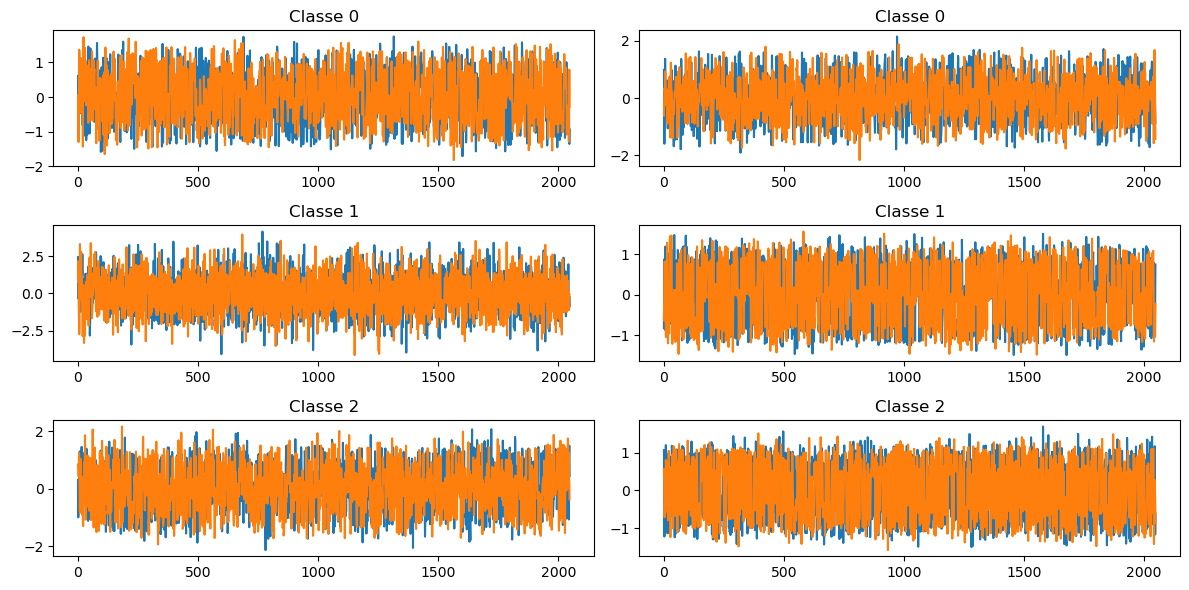

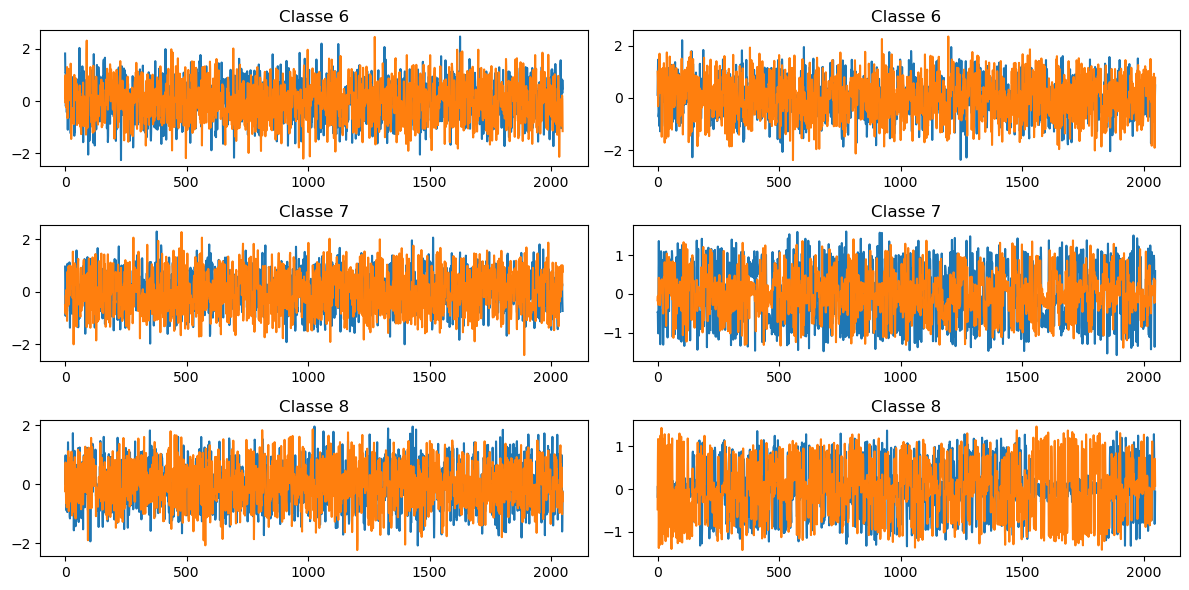

In [9]:
def plot_examples(path, classes_to_show, n=3):
    with h5py.File(path, "r") as f:
        X = f["signaux"][:]
        y = f["labels"][:]

    plt.figure(figsize=(12, 6))
    idx = 1

    for cls in classes_to_show:
        samples = X[y == cls][:n]
        for s in samples:
            plt.subplot(len(classes_to_show), n, idx)
            plt.plot(s)
            plt.title(f"Classe {cls}")
            plt.tight_layout()
            idx += 1

plot_examples(paths["train"], classes_to_show=[0,1,2], n=2)
plot_examples(paths["enroll"], classes_to_show=[6,7,8], n=2)


## Dataloaders

In [43]:
from torch.utils.data import Dataset

import torch
import torch.nn as nn

In [65]:
class BasicDataset(Dataset):
    def __init__(self, signals, labels, transform=None):
        self.signals = signals
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx]
        y = self.labels[idx]
        
        x = torch.tensor(x, dtype=torch.float32)
        x = x.permute(1,0)  

        return x, torch.tensor(y, dtype=torch.long)



In [66]:
with h5py.File(paths["train"], "r") as f:
    X_train_full = np.array(f["signaux"])
    y_train_full = np.array(f["labels"])


In [67]:
print("Shape X :", X_train_full.shape)
print("Shape y :", y_train_full.shape)
print("Classes :", np.unique(y_train_full))


Shape X : (30000, 2048, 2)
Shape y : (30000,)
Classes : [0 1 2 3 4 5]


In [68]:
from sklearn.model_selection import train_test_split



X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.1,
    stratify=y_train_full,
    random_state=42
)


In [69]:
train_dataset = BasicDataset(X_train, y_train)
val_dataset   = BasicDataset(X_val, y_val)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [70]:
xb, yb = next(iter(train_loader))
print(xb.shape, yb.shape)


torch.Size([64, 2, 2048]) torch.Size([64])


## Pipeline

### Encodeur + tête de classification entraînement

In [71]:
import torch 
import torch.nn as nn

In [ ]:
class Encoder(nn.Module):
    def __init__(self, emb_dim=64):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  
        )
        
        self.fc = nn.Linear(128, emb_dim) 
        
    def forward(self, x):
        x = self.cnn(x)         
        x = x.squeeze(-1)       
        x = self.fc(x)          
        return x


In [ ]:
class Classifier(nn.Module):
    def __init__(self, encoder, emb_dim=64):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(emb_dim, 6) 
    
    def forward(self, x):
        z = self.encoder(x)
        logits = self.fc(z)
        return logits


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

encoder = Encoder(emb_dim=64).to(device)
model = Classifier(encoder, emb_dim=64).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


from tqdm import tqdm

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0

    # tqdm sur train_loader
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        
        logits = model(xb)
        loss = criterion(logits, yb)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = train_correct / total
    train_loss = train_loss / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            total_val += yb.size(0)

    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"\nEpoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}\n")



Epoch 1/20 [Val]: 100%|██████████| 47/47 [00:04<00:00,  9.71it/s]



Epoch 1/20 | Train Loss: 1.2630 | Train Acc: 0.321 | Val Loss: 1.0911 | Val Acc: 0.430



Epoch 2/20 [Val]: 100%|██████████| 47/47 [00:04<00:00, 11.00it/s]



Epoch 2/20 | Train Loss: 0.9935 | Train Acc: 0.470 | Val Loss: 0.7511 | Val Acc: 0.573



Epoch 3/20 [Val]: 100%|██████████| 47/47 [00:04<00:00, 11.40it/s]



Epoch 3/20 | Train Loss: 0.6994 | Train Acc: 0.584 | Val Loss: 0.6591 | Val Acc: 0.583



Epoch 4/20 [Val]: 100%|██████████| 47/47 [00:05<00:00,  8.98it/s]



Epoch 4/20 | Train Loss: 0.6634 | Train Acc: 0.591 | Val Loss: 0.6481 | Val Acc: 0.600



Epoch 5/20 [Val]: 100%|██████████| 47/47 [00:04<00:00,  9.91it/s]



Epoch 5/20 | Train Loss: 0.6535 | Train Acc: 0.583 | Val Loss: 0.6576 | Val Acc: 0.579



Epoch 6/20 [Val]: 100%|██████████| 47/47 [00:04<00:00, 10.81it/s]



Epoch 6/20 | Train Loss: 0.6479 | Train Acc: 0.593 | Val Loss: 0.6336 | Val Acc: 0.591



Epoch 7/20 [Val]: 100%|██████████| 47/47 [00:04<00:00, 11.38it/s]



Epoch 7/20 | Train Loss: 0.6390 | Train Acc: 0.592 | Val Loss: 0.6487 | Val Acc: 0.582



Epoch 8/20 [Val]: 100%|██████████| 47/47 [00:05<00:00,  9.17it/s]



Epoch 8/20 | Train Loss: 0.6336 | Train Acc: 0.598 | Val Loss: 0.6271 | Val Acc: 0.595



Epoch 9/20 [Val]: 100%|██████████| 47/47 [00:04<00:00,  9.62it/s]



Epoch 9/20 | Train Loss: 0.6298 | Train Acc: 0.597 | Val Loss: 0.6260 | Val Acc: 0.600



Epoch 10/20 [Train]:  79%|███████▉  | 333/422 [01:01<00:16,  5.42it/s]


KeyboardInterrupt: 

In [76]:
torch.save(encoder.state_dict(), "encoder_trained.pth")


### Few shot

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1   = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2   = nn.BatchNorm1d(out_channels)

        self.skip = None
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.skip is not None:
            identity = self.skip(identity)

        out += identity
        return F.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()

        self.conv1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(4)

        self.block1 = ResidualBlock1D(64, 64)
        self.block2 = ResidualBlock1D(64, 128, stride=2)
        self.block3 = ResidualBlock1D(128, 128)

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.global_pool(x)
        x = x.squeeze(-1)
        return F.normalize(x, p=2, dim=1)



In [99]:
encoder = ResNet1D(n_classes=6)
encoder.load_state_dict(torch.load("resnet1.pth", map_location=device))
encoder.to(device)
encoder.eval()


ResNet1D(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (block1): ResidualBlock1D(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): ResidualBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential

In [ ]:
import types

def forward_fewshot(self, x):
    x = self.pool1(F.relu(self.bn1(self.conv1(x))))
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.global_pool(x)
    x = x.squeeze(-1)
    x = F.normalize(x, p=2, dim=1)
    return x  

encoder.forward = types.MethodType(forward_fewshot, encoder)


In [101]:
x = torch.randn(1, 2, 2048).to(device)
z = encoder(x)
print(z.shape)


torch.Size([1, 128])


In [102]:
with h5py.File(paths["enroll"], "r") as f:
    X_enroll = np.array(f["signaux"])
    y_enroll = np.array(f["labels"])


In [103]:
enroll_dict = {}
for c in np.unique(y_enroll):
    enroll_dict[c] = X_enroll[y_enroll == c]


In [ ]:
def compute_prototypes(encoder, enroll_dict, K, device):
    prototypes = {}
    for c, signals in enroll_dict.items():
        Xc = signals[:K]     

        Xc = torch.tensor(Xc, dtype=torch.float32).permute(0, 2, 1).to(device)
        

        with torch.no_grad():
            Zc = encoder(Xc)   

        prototypes[c] = Zc.mean(dim=0)

    return prototypes


prototypes = compute_prototypes(encoder, enroll_dict, K=5, device=device)


In [82]:
with h5py.File(paths["test"], "r") as f:
    X_test = np.array(f["signaux"])
    y_test = np.array(f["labels"])


In [83]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)


In [105]:
def predict_fewshot(x, prototypes):
    best_c = None
    best_dist = float("inf")

    for c, proto in prototypes.items():
        dist = torch.dist(x, proto)
        if dist < best_dist:
            best_dist = dist
            best_c = c
    return best_c

correct = 0

for i in range(len(X_test_tensor)):
    x = X_test_tensor[i].unsqueeze(0).to(device)

    with torch.no_grad():
        z = encoder(x).squeeze(0)

    pred = predict_fewshot(z, prototypes)
    if pred == y_test[i]:
        correct += 1

acc = correct / len(X_test_tensor)
print("Few-shot accuracy:", acc)



Few-shot accuracy: 0.67
